# MNIST Handwritten Digits Recognition

## Importing the required packages

In [2]:
import numpy as np 
import torch 
from torchvision import datasets,transforms
import matplotlib.pyplot as plt 
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

## Defining our Transform

In [3]:
transform=transforms.ToTensor()

## Gathering the train and test data

In [4]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transform)
test_data=datasets.MNIST('data',train=False,download=True,transform=transform)

## Defining our Train, Valid and Test Dataloaders

In [5]:
valid_size=0.2
batch_size=20
num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

print(f"Train data size : {train_idx.__len__()}, Valdiation data size : {valid_idx.__len__()}, Test data size : {test_loader.dataset.__len__()}")

Train data size : 48000, Valdiation data size : 12000, Test data size : 10000


In [6]:
# checking our data
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

## Visualizing a Training batch

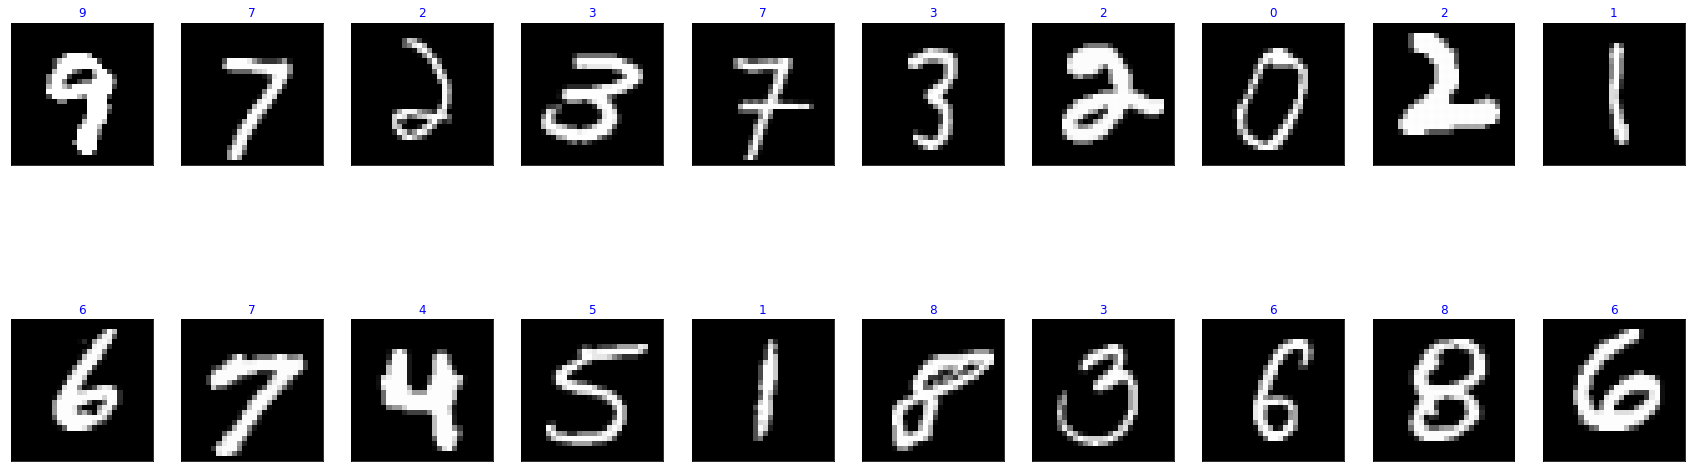

In [7]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]),cmap='gray')
    ax.set_title(labels[i].item(),color='blue')

## Defining our Neural Net Architecture

In [8]:
"""
 This model has dropout set to a certain value
 NOTE : 
 When we want to use dropout we ensure we run .train() method on our model ---> during training phase
 If not required we should use .eval() method ---> during validation and testing phase
 """
class classicMNIST(nn.Module):
    def __init__(self):
        super(classicMNIST,self).__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        
        # Dropout probability - set for avoiding overfitting
        self.dropout=nn.Dropout(0.2)

    def forward(self,x):
        # Flatten image
        x = x.view(-1, 28 * 28)        
        x=self.dropout(torch.sigmoid(self.fc1(x)))
        x=self.dropout(torch.sigmoid(self.fc2(x)))
        x=self.out(x)
        return x

In [9]:
model=classicMNIST()
use_cuda=True
if use_cuda and torch.cuda.is_available():
  model.cuda()
print(f"Our Model : {model}, GPU Available : {torch.cuda.is_available()}")

Our Model : classicMNIST(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
), GPU Available : False


## Defining our Loss Function and Optimizer

In [10]:
# Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()
criterion=nn.CrossEntropyLoss()

# Learning Rate
lr=0.001
# Optimizer 
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

## Training and Validation Phase

In [10]:
# Number of epochs to train for
loss_keeper={'train':[],'valid':[]}
epochs=20

# minimum validation loss ----- set initial minimum to infinity
valid_loss_min = np.Inf 

for epoch in range(epochs):
  train_loss=0.0
  valid_loss=0.0

  """
  TRAINING PHASE
  """
  model.train() # TURN ON DROPOUT for training
  for images,labels in train_loader:
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    optimizer.zero_grad()
    output=model(images)
    loss=criterion(output,labels)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()*images.size(0)

  """
  VALIDATION PHASE
  """
  model.eval() # TURN OFF DROPOUT for validation
  for images,labels in valid_loader:
    output=model(images)
    loss=criterion(output,labels)
    valid_loss+=loss.item()*images.size(0)

  # Calculating loss over entire batch size for every epoch
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)


  # saving loss values
  loss_keeper['train'].append(train_loss)
  loss_keeper['valid'].append(valid_loss)

  print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
  if valid_loss<=valid_loss_min:
    print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
    torch.save(model.state_dict(), 'model.pt')
    valid_loss_min=valid_loss



Epoch : 1	Training Loss : 0.32049132008478043	Validation Loss : 0.03817275898065418
Validation loss decreased from : inf ----> 0.03817275898065418 ----> Saving Model.......

Epoch : 2	Training Loss : 0.1308493085481071	Validation Loss : 0.02384380437519091
Validation loss decreased from : 0.03817275898065418 ----> 0.02384380437519091 ----> Saving Model.......

Epoch : 3	Training Loss : 0.09000828862950827	Validation Loss : 0.020126738044898958
Validation loss decreased from : 0.02384380437519091 ----> 0.020126738044898958 ----> Saving Model.......

Epoch : 4	Training Loss : 0.06897166594172208	Validation Loss : 0.016540910755827403
Validation loss decreased from : 0.020126738044898958 ----> 0.016540910755827403 ----> Saving Model.......

Epoch : 5	Training Loss : 0.05394049775812891	Validation Loss : 0.015477357589047945
Validation loss decreased from : 0.016540910755827403 ----> 0.015477357589047945 ----> Saving Model.......

Epoch : 6	Training Loss : 0.042731707730650666	Validation 

## Loading model from Lowest Validation Loss

In [11]:
model.load_state_dict(torch.load('model.pt'))
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0068,  0.0105,  0.0161,  ..., -0.0010,  0.0257, -0.0112],
                      [ 0.0066, -0.0055, -0.0341,  ...,  0.0180,  0.0108, -0.0237],
                      [ 0.0046, -0.0138,  0.0087,  ...,  0.0323,  0.0267, -0.0026],
                      ...,
                      [-0.0181, -0.0214,  0.0240,  ...,  0.0118,  0.0228,  0.0146],
                      [-0.0321, -0.0111, -0.0209,  ...,  0.0009, -0.0231, -0.0256],
                      [-0.0100,  0.0028,  0.0176,  ...,  0.0038,  0.0223,  0.0176]])),
             ('fc1.bias',
              tensor([ 8.1415e-02,  1.3846e-01, -1.4125e-01, -7.7835e-02, -1.5855e-01,
                      -6.6410e-02, -7.0177e-02, -1.2264e-01,  1.0473e-02, -1.0101e-01,
                      -3.6673e-01, -2.2625e-02, -8.8406e-02, -2.7973e-01, -1.5147e-01,
                      -2.7539e-01, -2.8777e-02, -1.4420e-02, -1.0997e-01, -5.9245e-02,
                      -1.2251e-01, -1.0997e-01,  8.0472e-04, -1.

## Plotting Training and Validation Losses

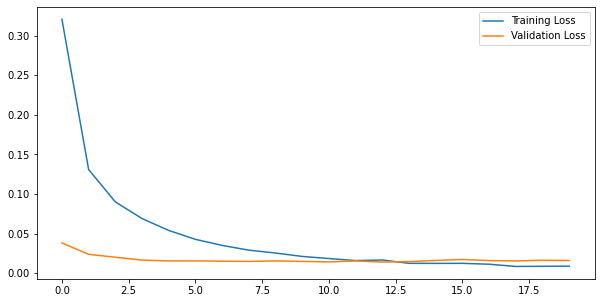

In [12]:
plt.figure(1,figsize=(10,5))
plt.plot(loss_keeper['train'],label="Training Loss")
plt.plot(loss_keeper['valid'],label="Validation Loss")
plt.legend();

## Testing Phase

In [12]:
correct=0
test_loss=0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # test the model with dropout layers off
for images,labels in test_loader:
    output=model(images)
    loss=criterion(output,labels)
    test_loss+=loss.item()*images.size(0)
    _,pred=torch.max(output,1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss=test_loss/len(test_loader.dataset)

print(f"Test Loss : {test_loss}")
print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {int(sum(class_correct))}")
print(f"Total Predictions per class : {class_total}, Total predictions to be made : {int(sum(class_total))}")

for i in range(10):
    if class_total[i] > 0:
        print(f"\nTest Accuracy of class {i} : {int(100 * class_correct[i] / class_total[i])}% where {int(class_correct[i])} of {int(class_total[i])} were predicted correctly")



print(f"\nOverall Test Accuracy : {int(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")

Test Loss : 0.0754211479874557
Correctly predicted per class : [974.0, 1127.0, 1008.0, 992.0, 955.0, 867.0, 939.0, 1013.0, 948.0, 988.0], Total correctly perdicted : 9811
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0], Total predictions to be made : 10000

Test Accuracy of class 0 : 99% where 974 of 980 were predicted correctly

Test Accuracy of class 1 : 99% where 1127 of 1135 were predicted correctly

Test Accuracy of class 2 : 97% where 1008 of 1032 were predicted correctly

Test Accuracy of class 3 : 98% where 992 of 1010 were predicted correctly

Test Accuracy of class 4 : 97% where 955 of 982 were predicted correctly

Test Accuracy of class 5 : 97% where 867 of 892 were predicted correctly

Test Accuracy of class 6 : 98% where 939 of 958 were predicted correctly

Test Accuracy of class 7 : 98% where 1013 of 1028 were predicted correctly

Test Accuracy of class 8 : 97% where 948 of 974 were predicted correctly

Test Accura

## Visualizing a Test batch with results

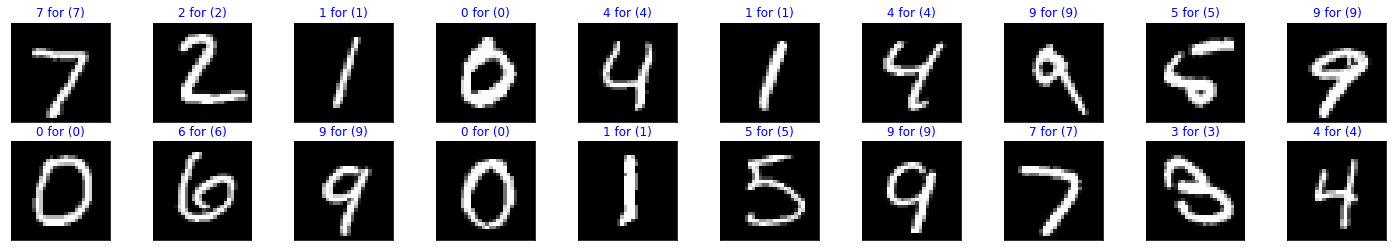

In [32]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} for ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("blue" if preds[idx]==labels[idx] else "red"))